## **Module 3 Final Project**

    Title: Northwind Database
    Submitted By: RU KEÏN
    Date: December 5, 2019
    Instructor: James Irving PhD
    https://vimeo.com/rukein/northwind-datascience-project-presentation
    http://www.hakkeray.com/datascience/2019/12/07/thinking-outside-the-lego-box.html

---
## Executive Summary

The goal of this project is to recommend business strategies for increasing sales and saving costs for the Northwind company. This project is based on a fictitious business database created by Microsoft for the use of practicing SQL, hypothesis testing and other data analysis related projects. 

Below are 4 hypotheses (each including a null hypothesis and alternative hypothesis) which I will test for statistical significance to determine if there are any relationships which would be useful from a strategic business perspective. Following this I will summarize the results, make final recommendations, and propose ideas for future analytical work.

---
## Outline

*Statistical Analysis Pipeline*

For each question below, I will follow a standard process of work as outlined here:
- 1. Question
    - 1.1 Hypotheses
    - 1.2 Exploratory Data Analysis (EDA)
        - 1.2.1 Select dataset
        - 1.2.2 Group data
        - 1.2.3 Explore data
    - 1.3 Test
        - 1.3.1 Sample size
        - 1.3.2 Normality and Variance
        - 1.3.3 Statistical test
        - 1.3.4 Effect size (if necessary)
        - 1.3.5 Post-hoc tests (if necessary)
    - 1.4 Analyze Results


---

The statistical testing process is as follows (section 1.4 above):

1. Check if sample sizes allow us to ignore assumptions by visualizing sample size comparisons for two groups (normality check).
    * Bar Plot: SEM (Standard Error of the Mean)

2. If above test fails, check for normality and homogeneity of variance:
    * Test Assumption Normality:
        - D'Agostino-Pearson: scipy.stats.normaltest
        - Shapiro-Wilik Test: scipy.stats.shapiro
    
    * Test for Homogeneity of Variance:
        - Levene's Test: scipy.stats.levene)

3. Choose appropriate test based on above
    * T Test (1-sample)
         - stats.ttest_1samp()
    * T Test (2-sample)
        - stats.ttest_ind()
    * Welch's T-Test (2-sample)
        - stats.ttest_ind(equal_var=False)
    * Mann Whitney U
        - stats.mannwhitneyu()
    * ANOVA
        - stats.f_oneway()
    * Tukey's
        - statsmodels.stats.multicomp.pairwise_tukeyhsd

4. Calculate effect size for significant results.
    * Effect size: 
        - cohen's d

    -Interpretation:
    - Small effect = 0.2 ( cannot be seen by naked eye)
    - Medium effect = 0.5
    - Large Effect = 0.8 (can be seen by naked eye)


5. If significant, follow up with post-hoc tests (if have more than 2 groups)
    * Tukey's

--------------------------
## Table of Contents

0. Data Prep

1. H1: Discount and Order Quantity
Does discount amount have a statistically significant effect on quantity of product 
in an order? If so, at what level(s) of discount?

2. H2: Discount and Country
Do individual countries tend to order more products when a discount is offered? 

3. H3: Region and Sales Revenue
Does sales revenue vary by region?

4. H4: Time of Year (Season) and Revenue/Units Sold
Does time of year have a statistically significant effect on sales revenue and/or volume of units sold? 

5. Conclusion

6. Recommendations

7. Future Work
    * A. Product Recommendation Tool
    * B. Free/Discounted Shipping

## Data Prep

In [1]:
# install requisite libraries and packages
!pip install -U fsds_100719 --user
from fsds_100719.imports import *

fsds_1007219  v0.4.45 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [197]:
from fsds_100719.ds import ihelp, reload
import fsds_100719 as fs

In [199]:
fs.ft.hakkeray.hot_stats()

<module 'fsds_100719.ft.hakkeray' from '/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/fsds_100719/ft/hakkeray.py'>

In [201]:
# connect to database / import data
import sqlite3 
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [203]:
# function for converting tables into dataframes on the fly
def get_table(cur, table):
    cur.execute(f"SELECT * from {table};")
    df = pd.DataFrame(cur.fetchall())
    df.columns = [desc[0] for desc in cur.description]
    return df

In [202]:
# create dataframe of table names for referencing purposes
cur.execute("""SELECT name from sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


In [256]:
from IPython.display import HTML
HTML('<img src="https://github.com/hakkeray/dsc-mod-3-project-online-ds-ft-100719/blob/master/Northwind_ERD_updated.png?raw=true">')


# H1: Discount--Quantity

* Does discount amount have a statistically significant effect on the quantity of a product in an order? 
* If so, at what level(s) of discount?

## Hypotheses
- $H_0$: Discount amount has no relationship with the quantity of a product in an order.
- $H_A$: Discount amount has a statistically significant effect on the quantity in an order.

- $\alpha$=0.05

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

### Select dataset

In [208]:
df_orderDetail = get_table(cur, 'OrderDetail')
df_orderDetail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Group

In [209]:
# check value counts for each level of discount
df_orderDetail['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [212]:
# insert boolean column showing whether or not an order was discounted
df_orderDetail['discounted'] = np.where(df_orderDetail['Discount'] == 0.0, 0, 1)

# compare number of discount vs fullprice orders
df_orderDetail['discounted'].value_counts()

0    1317
1     838
Name: discounted, dtype: int64

In [216]:
# split orders into two groups: discount and fullprice
fullprice = df_orderDetail.groupby('discounted').get_group(0)['Quantity']
discount = df_orderDetail.groupby('discounted').get_group(1)['Quantity']

display(fullprice.head())
display(discount.head())

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64

6     35
7     15
8      6
9     15
11    40
Name: Quantity, dtype: int64

### Explore

In [214]:
fullprice.mean()

21.715261958997722

In [215]:
discount.mean()

27.10978520286396

At first glance it looks like the average quantities are indeed higher for discounted orders compared to those that are full price.

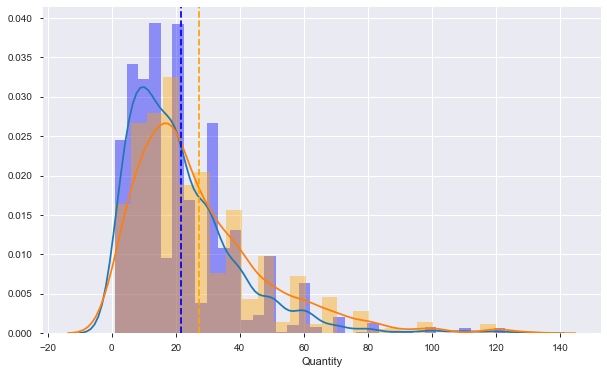

In [228]:
## Examine KDEs
fig, ax = plt.subplots(figsize=(10,6))

group1 = {'name':'fullprice',
         'data':fullprice,
         'n':fullprice.value_counts()}
plot1 = {'hist_kws':dict(color='blue',lw=2, ls='-')}

group2 = {'name':'discount',
         'data':discount,
         'n':discount.value_counts()}
plot2 = {'hist_kws':dict(color='orange',lw=2, ls='-')}


label1= f"{group1['name']} n={group1['n']}"
sns.distplot(group1['data'], label=label1,
             ax=ax, hist_kws=plot1['hist_kws'])
# ax.legend()

label2= f"{group2['name']} n={group2['n']}"
sns.distplot(group2['data'], label=label2,
             ax=ax,hist_kws=plot2['hist_kws'])
# ax.legend()

ax.axvline(group1['data'].mean(),color=plot1['hist_kws']['color'], ls='--')
ax.axvline(group2['data'].mean(),color=plot2['hist_kws']['color'], ls='--')

## Test
**Select the appropriate t-test based on tests for the assumptions of normality and homogeneity of variance.**

### Sample Size
Check if sample sizes allow us to ignore assumptions; if not, test assumption normality.

<BarContainer object of 1 artists>

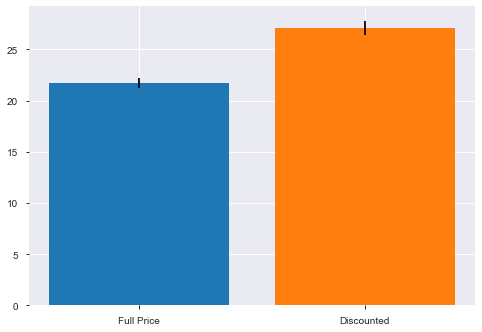

In [220]:
# visualize sample size comparisons for two groups (normality check)
import scipy.stats as stat
plt.bar(x='Full Price', height=fullprice.mean(), yerr=stat.sem(fullprice))
plt.bar(x='Discounted', height=discount.mean(), yerr=stat.sem(discount))

### Normality Test
Check assumptions of normality and homogeneity of variance

In [221]:
# Test for normality - D'Agostino-Pearson's normality test: scipy.stats.normaltest
stat.normaltest(fullprice), stat.normaltest(discount)

(NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119),
 NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57))

Failed normality test (p-values < 0.05). Run non-parametric test:

In [229]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(fullprice, discount)

MannwhitneyuResult(statistic=461541.0, pvalue=6.629381826999866e-11)

### Statistical Test
Perform chosen statistical test.

In [230]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_orderDetail['Quantity'].values
labels = df_orderDetail['Discount'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

In [231]:
# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
1,0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
2,0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
3,0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
4,0.0,0.05,6.2955,0.0011,1.5381,11.053,True
5,0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
6,0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
7,0.0,0.15,6.6669,0.0014,1.551,11.7828,True
8,0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
9,0.0,0.25,6.525,0.0023,1.3647,11.6852,True


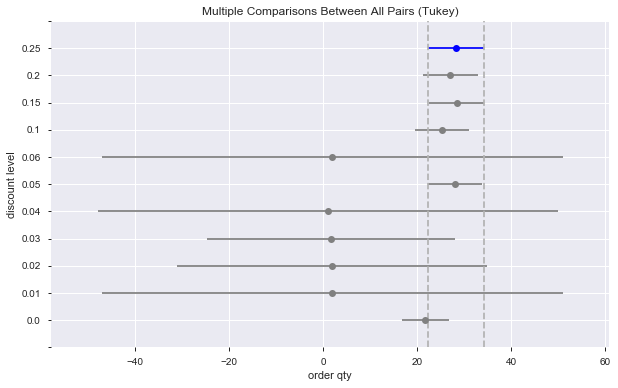

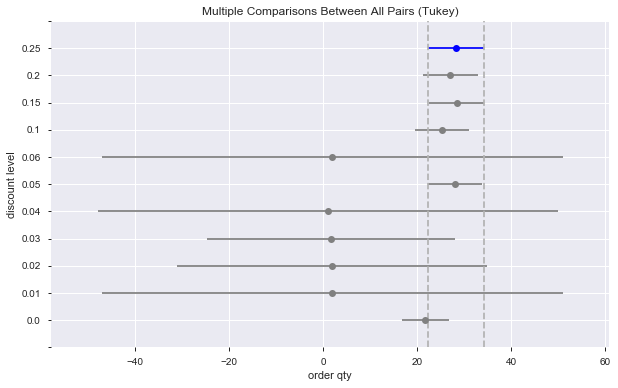

In [269]:
# Plot a universal confidence interval of each group mean comparing significant differences in group means. 
# Significant differences at the alpha=0.05 level can be identified by intervals that do not overlap 

oq_data = df_orderDetail['Quantity'].values
discount_labels = df_orderDetail['Discount'].values

from statsmodels.stats.multicomp import MultiComparison
oqd = MultiComparison(oq_data, discount_labels)
results = oqd.tukeyhsd()
results.plot_simultaneous(comparison_name=0.25, xlabel='order qty', ylabel='discount level')

### Effect Size
Calculate effect size using Cohen's D as well as any post-hoc tests.

In [233]:
#### Cohen's d
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [234]:
Cohen_d(discount, fullprice)

0.2862724481729282

### Post-hoc Tests

In [266]:
df_oqd = df_orderDetail.loc[(df_orderDetail['Discount'] >= 0.05) & (df_orderDetail['Discount'] != 0.06) & (df_orderDetail['Discount'] != 0.1)]
df_oqd

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
6,10250/51,10250,51,42.4,35,0.15,1
7,10250/65,10250,65,16.8,15,0.15,1
8,10251/22,10251,22,16.8,6,0.05,1
9,10251/57,10251,57,15.6,15,0.05,1
11,10252/20,10252,20,64.8,40,0.05,1
...,...,...,...,...,...,...,...
2129,11076/19,11076,19,9.2,10,0.25,1
2130,11077/2,11077,2,19.0,24,0.20,1
2134,11077/7,11077,7,30.0,1,0.05,1
2137,11077/12,11077,12,38.0,2,0.05,1


In [274]:
df_oqd['OQD'] = 1
df_oqd

/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD
6,10250/51,10250,51,42.4,35,0.15,1,1
7,10250/65,10250,65,16.8,15,0.15,1,1
8,10251/22,10251,22,16.8,6,0.05,1,1
9,10251/57,10251,57,15.6,15,0.05,1,1
11,10252/20,10252,20,64.8,40,0.05,1,1
...,...,...,...,...,...,...,...,...
2129,11076/19,11076,19,9.2,10,0.25,1,1
2130,11077/2,11077,2,19.0,24,0.20,1,1
2134,11077/7,11077,7,30.0,1,0.05,1,1
2137,11077/12,11077,12,38.0,2,0.05,1,1


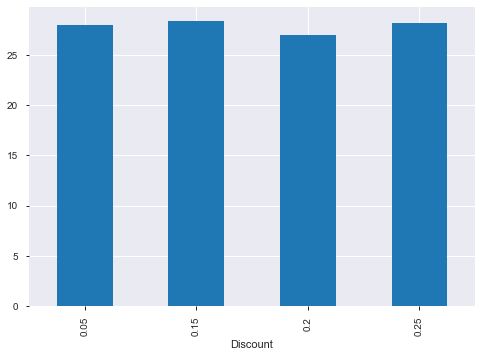

In [271]:
df_oqd.groupby(['Discount'])['Quantity'].mean().plot.bar()

(array([185.,   0., 157., 315.]),
 array([0.05, 0.1 , 0.15, 0.2 , 0.25]),
 <a list of 4 Patch objects>)

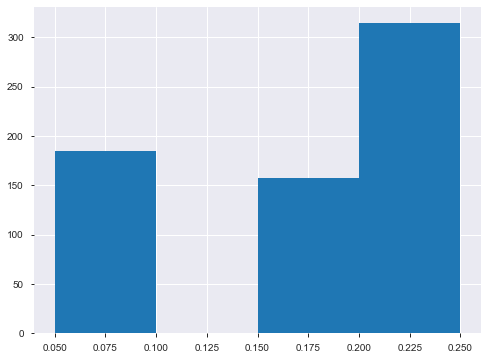

In [282]:
fig = plt.figure(figsize=(8,6))
plt.hist(data=df_oqd, x='Discount', bins=dv)

In [281]:
df_orderDetail['OQD'] = df_oqd['OQD']
df_orderDetail['OQD'].fillna(0, inplace=True)
df_orderDetail['OQD'].value_counts()

0.0    1498
1.0     657
Name: OQD, dtype: int64

In [291]:
# dataframe containing insignificant discount levels
fullprice_df = df_orderDetail.loc[df_orderDetail['OQD'] == 0]
# dataframe containing significant discount levels
discount_df = df_orderDetail.loc[df_orderDetail['OQD'] == 1]

In [292]:
mean_qty_fp = fullprice_df.Quantity.mean()
mean_qty_dc = discount_df.Quantity.mean()
print(mean_qty_fp, mean_qty_dc)

22.01535380507343 27.911719939117198


In [293]:
diff = mean_qty_dc - mean_qty_fp
diff

5.896366134043767

In [53]:
from pandas_profiling import ProfileReport
#ProfileReport(df_oqd)

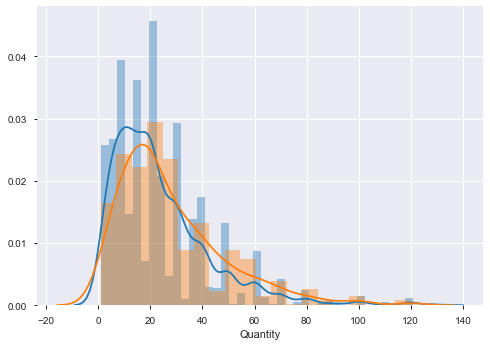

In [290]:
sns.distplot(df_orderDetail.Quantity)
sns.distplot(df_oqd.Quantity)

## Analyze Results

The null hypothesis is rejected. Discount amount has a statistically significant effect on the quantity in an order where the discount level is equal to 5%, 15%, 20% or 25%.

NOTES - be more precise (pvalue for test and effect size, therefore rejecting etc)

# H2: Country--Discount

**Do individual countries show a statistically significant preference for discount?**

**If so, which countries and to what extent?** 

## Hypotheses

- $H_0$: Countries purchase equal quantities of discounted vs non-discounted products.
- $H_A$: Countries purchase different quantities of discounted vs non-discounted products.

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

### Select

In [294]:
df_order = get_table(cur, "'Order'")
display(df_order.head())
display(df_orderDetail.head())

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD
0,10248/11,10248,11,14.0,12,0.0,0,0.0
1,10248/42,10248,42,9.8,10,0.0,0,0.0
2,10248/72,10248,72,34.8,5,0.0,0,0.0
3,10249/14,10249,14,18.6,9,0.0,0,0.0
4,10249/51,10249,51,42.4,40,0.0,0,0.0


In [295]:
# Rename 'Id' to 'OrderId' for joining tables with matching primary key name
df_order.rename({'Id':'OrderId'}, axis=1, inplace=True)
display(df_order.head())

,OrderId,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


### Explore

In [296]:
df_order.set_index('OrderId',inplace=True)
display(df_order.head())

,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
OrderId,,,,,,,,,,,,,
10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


### Group

In [297]:
df_countries = df_orderDetail.merge(df_order, on='OrderId', copy=True)
df_countries.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD,CustomerId,EmployeeId,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,0,0.0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,0,0.0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,0,0.0,VINET,5,...,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,0,0.0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,0,0.0,TOMSP,6,...,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [298]:
countries = df_countries.groupby('ShipCountry').groups
countries.keys()

dict_keys(['Argentina', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Ireland', 'Italy', 'Mexico', 'Norway', 'Poland', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'UK', 'USA', 'Venezuela'])

In [310]:
df_countries.loc[df_countries['discounted'] == 1]['ShipCountry'].value_counts()

Germany        150
USA            142
Brazil          95
France          77
Austria         58
Venezuela       46
Sweden          39
Ireland         35
Canada          31
Italy           27
UK              26
Switzerland     24
Denmark         19
Portugal        18
Finland         15
Spain           14
Belgium         14
Mexico           8
Name: ShipCountry, dtype: int64

In [311]:
df_countries.loc[df_countries['discounted'] == 0]['ShipCountry'].value_counts()

USA            210
Germany        178
UK             109
Brazil         108
France         107
Venezuela       72
Austria         67
Mexico          64
Sweden          58
Canada          44
Belgium         42
Spain           40
Finland         39
Argentina       34
Switzerland     28
Denmark         27
Italy           26
Ireland         20
Norway          16
Poland          16
Portugal        12
Name: ShipCountry, dtype: int64

## Test

### Sample Size

Argentina does not contain one of the groups.
Austria


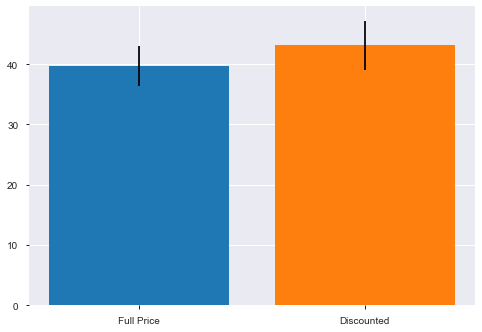

Belgium


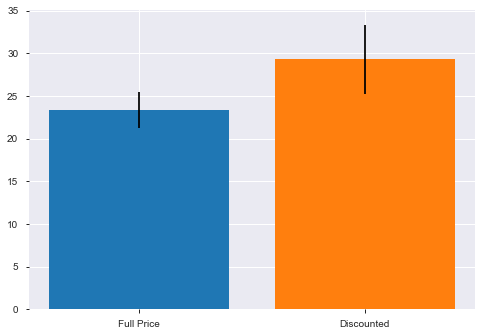

Brazil


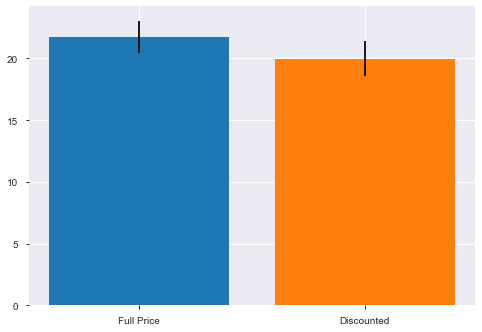

Canada


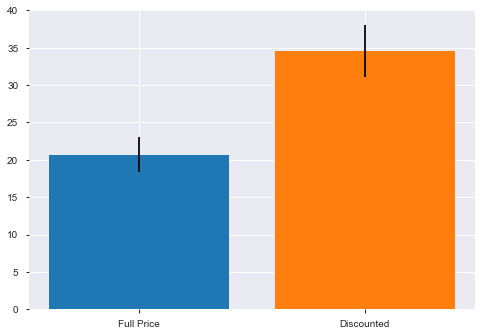

Denmark


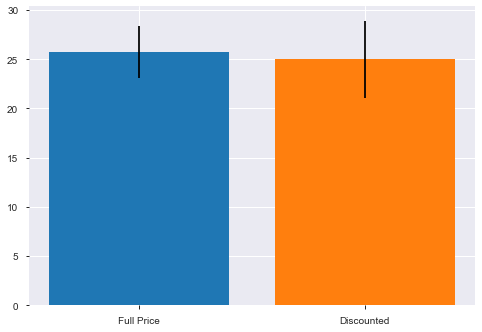

Finland


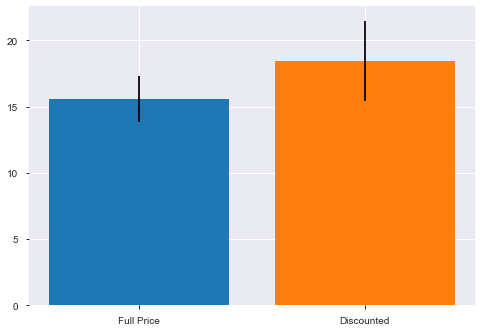

France


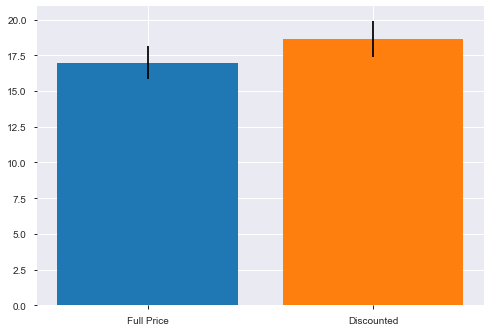

Germany


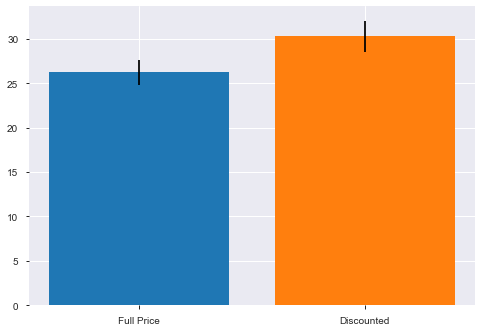

Ireland


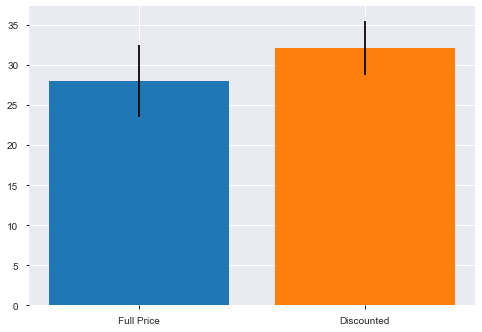

Italy


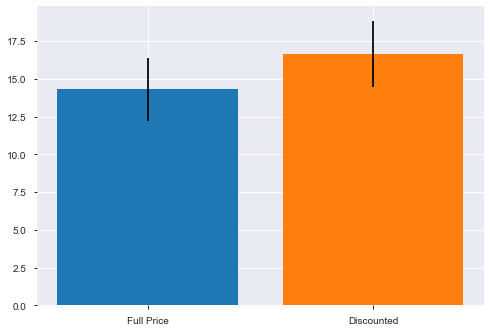

Mexico


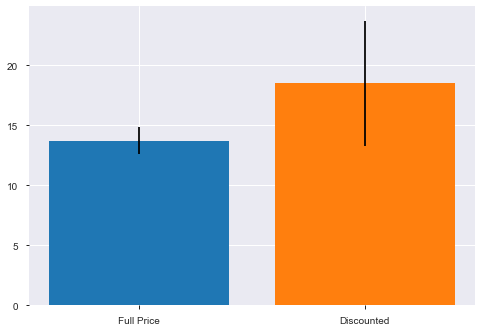

Norway does not contain one of the groups.
Poland does not contain one of the groups.
Portugal


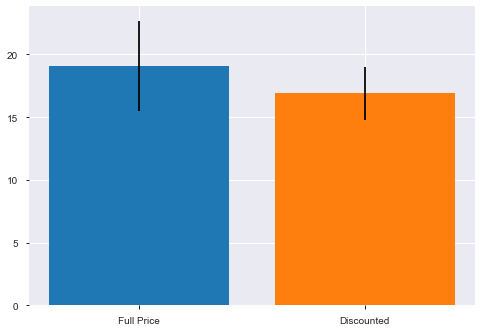

Spain


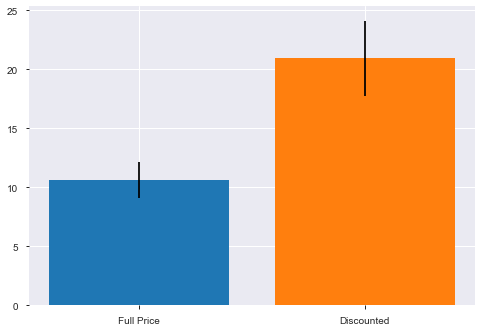

Sweden


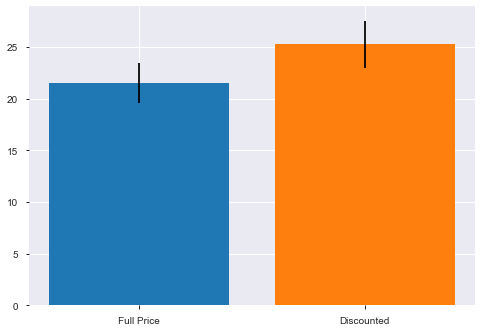

Switzerland


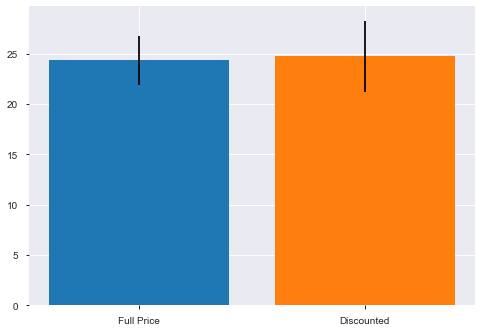

UK


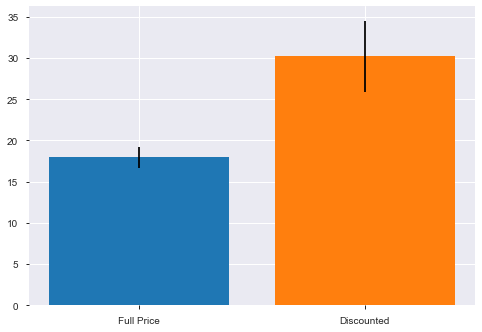

USA


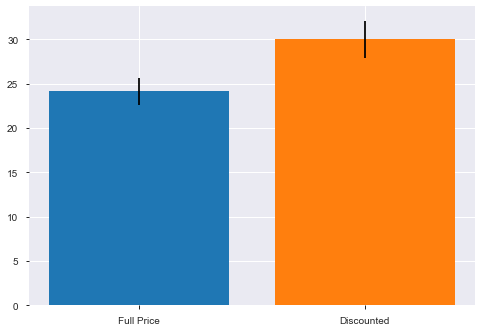

Venezuela


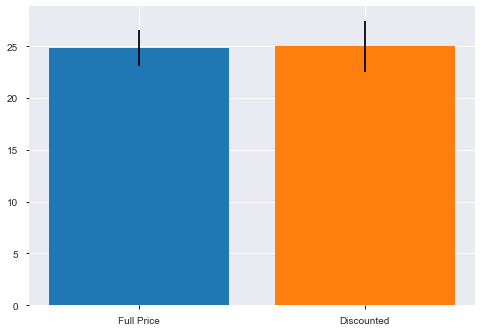

In [341]:
# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons for two groups (normality check)
for k,v in countries.items():
    try:
        grp0 = df_countries.loc[v].groupby('discounted').get_group(0)['Quantity']
        grp1 = df_countries.loc[v].groupby('discounted').get_group(1)['Quantity']
        print(f"{k}")
        import scipy.stats as stat
        plt.bar(x='Full Price', height=grp0.mean(),
               yerr=stat.sem(grp0))
        plt.bar(x='Discounted', height=grp1.mean(),
               yerr=stat.sem(grp1))
        plt.show()
    except:
        print(f"{k} does not contain one of the groups.")

### Normality Test

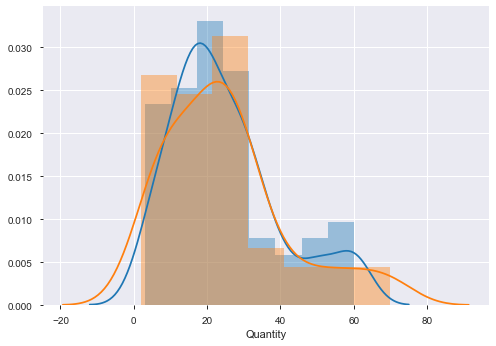

In [344]:
sns.distplot(grp0)
sns.distplot(grp1)

In [364]:
# Test for normality - D'Agostino-Pearson's normality test: scipy.stats.normaltest
stat.normaltest(grp0), stat.normaltest(grp1)

(NormaltestResult(statistic=9.316225653095811, pvalue=0.009484344125890621),
 NormaltestResult(statistic=10.255309993341813, pvalue=0.005930451108115991))

In [365]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(grp0, grp1)

MannwhitneyuResult(statistic=1632.5, pvalue=0.44935140740973323)

**Canada, Spain, UK and the USA have pvalues < 0.05 indicating there is a relationship between discount and order quantity and the null hypothesis is rejected for these individual countries.**

In [317]:
# test normality assumption
for k,v in countries.items():
    try:
        grp0 = df_countries.loc[v].groupby('discounted').get_group(0)['Quantity']
        grp1 = df_countries.loc[v].groupby('discounted').get_group(1)['Quantity']
        result = stat.ttest_ind(grp0,grp1)
        if result[1] < 0.05:
            print(f"\n{k} PREFERS DISCOUNTS!")
        else:
            print(f"\n{k}")
        print(result)
    except:
        print(f"{k} does not contain one of the groups.")

Argentina does not contain one of the groups.

Austria
Ttest_indResult(statistic=-0.6623269022307275, pvalue=0.5090008404811379)

Belgium
Ttest_indResult(statistic=-1.3489126055424439, pvalue=0.18299467630787178)

Brazil
Ttest_indResult(statistic=0.9101788952517438, pvalue=0.36381833828838683)

Canada PREFERS DISCOUNTS!
Ttest_indResult(statistic=-3.4195803456201843, pvalue=0.0010297982736886485)

Denmark
Ttest_indResult(statistic=0.16182691149215328, pvalue=0.8721830022491708)

Finland
Ttest_indResult(statistic=-0.8608852977352008, pvalue=0.39325342251232176)

France
Ttest_indResult(statistic=-0.9806435498249095, pvalue=0.32807031410690046)

Germany
Ttest_indResult(statistic=-1.8173101934160463, pvalue=0.07008759031616896)

Ireland
Ttest_indResult(statistic=-0.7429260971205413, pvalue=0.4608068502897392)

Italy
Ttest_indResult(statistic=-0.7780531564455361, pvalue=0.44013244003386054)

Mexico
Ttest_indResult(statistic=-1.3194239082443096, pvalue=0.19132685241353548)
Norway does not con

### Statistical Test

In [324]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols("Quantity~C(discounted)+C(ShipCountry)+C(discounted):C(ShipCountry)", data=df_countries).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 18
  'rank is %d' % (J, J_), ValueWarning)
/Users/hakkeray/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 18
  'rank is %d' % (J, J_), ValueWarning)


In [325]:
# reformat scientific notation of results for easier interpretation
anova_table.style.format("{:.5f}", subset=['PR(>F)'])

,sum_sq,df,F,PR(>F)
C(discounted),9.78092e-08,1,3.07557e-10,0.99999
C(ShipCountry),101347,20,15.9341,0.00000
C(discounted):C(ShipCountry),15584.9,20,2.4503,0.00061
Residual,672930,2116,nan,nan


Although discount does not have a significant effect on countries overall (p = 0.99), there is a statistically significant relationship between order quantities and discount in some of the countries (p=0.0006).

According to the SEM bar plots and ttest statistics above, countries showing a preference for discount include:
* Spain
* UK
* Canada
* USA

### Effect Size

Effect size testing is unnecessary since the null hypothesis for the main question was not rejected.

In [327]:
# Part 2: To what extent (percentage difference) do countries order discount vs full price
discountry_df = df_countries[df_countries.ShipCountry.isin(['Spain','UK','USA','Canada'])]
discountry_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD,CustomerId,EmployeeId,...,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
40,10262/5,10262,5,17.0,12,0.20,1,1.0,RATTC,8,...,2012-08-19,2012-07-25,3,48.29,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA
41,10262/7,10262,7,24.0,15,0.00,0,0.0,RATTC,8,...,2012-08-19,2012-07-25,3,48.29,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA
42,10262/56,10262,56,30.4,2,0.00,0,0.0,RATTC,8,...,2012-08-19,2012-07-25,3,48.29,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA
57,10269/33,10269,33,2.0,60,0.05,1,1.0,WHITC,5,...,2012-08-14,2012-08-09,1,4.56,White Clover Markets,1029 - 12th Ave. S.,Seattle,North America,98124,USA
58,10269/72,10269,72,27.8,20,0.05,1,1.0,WHITC,5,...,2012-08-14,2012-08-09,1,4.56,White Clover Markets,1029 - 12th Ave. S.,Seattle,North America,98124,USA


In [328]:
#!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

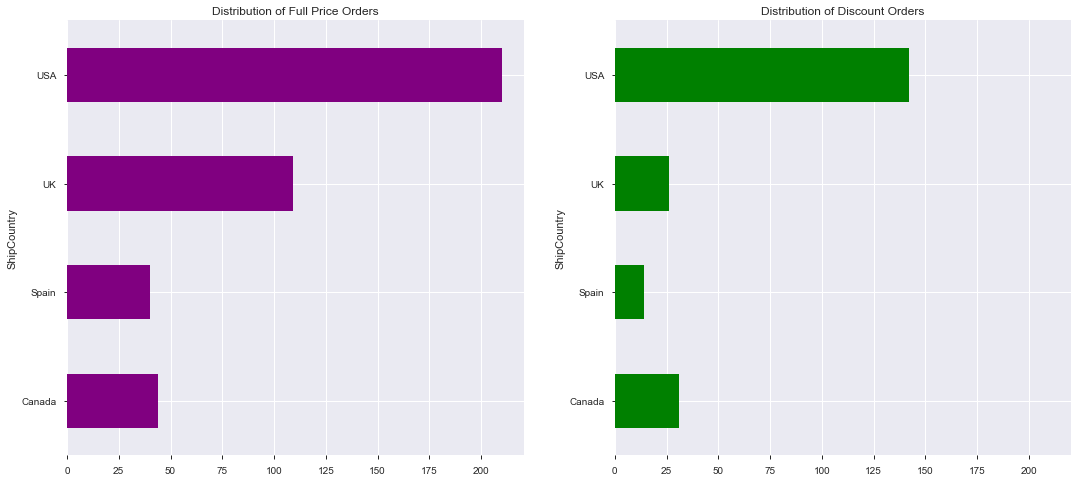

In [330]:
# Plot comparison of discount orders vs fullprice orders for each country where a significant difference exists.
#Spain
q0 = "SELECT ShipCountry, Count(*) from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, Count(*) from discountry_df where discounted = 1 group by 1;"

fullprice_df = pysqldf(q0)
discount_df = pysqldf(q1)

# Create histograms for each query group
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8), sharex=True)

ax0 = axes[0]
fullprice_df.set_index('ShipCountry')['Count(*)'].plot(kind='barh', ax=ax0, color='purple')
ax0.set_title('Distribution of Full Price Orders')

ax1 = axes[1]
discount_df.set_index('ShipCountry')['Count(*)'].plot(kind='barh', ax=ax1, color='green')
ax1.set_title('Distribution of Discount Orders')
plt.show()

According to the plot above, the actual number of discounted orders is lower than the number of full price orders. Let's compare the sum of quantities for these orders in each group.

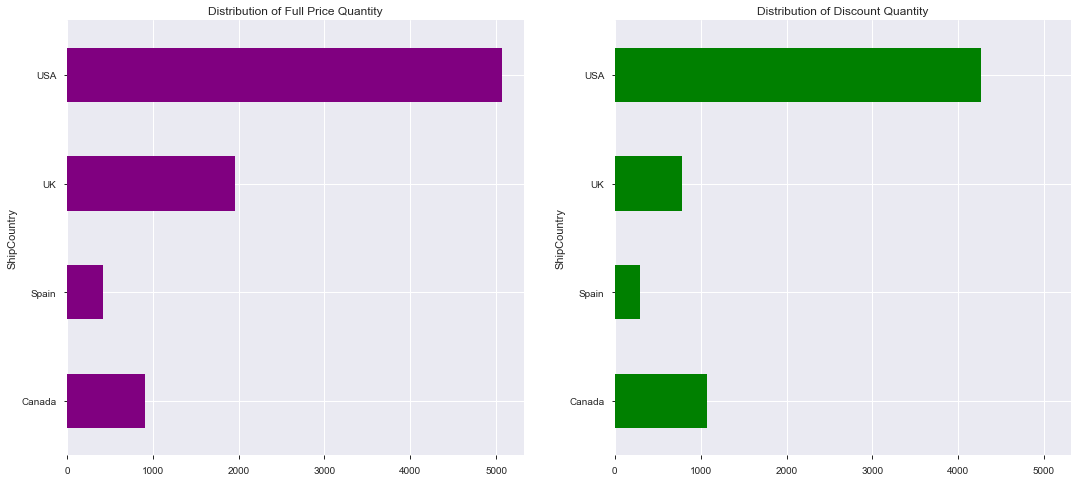

In [331]:
# Plot comparison of discount orders vs fullprice orders for each country where a significant difference exists.
#Spain
q0 = "SELECT ShipCountry, SUM(Quantity) from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, SUM(Quantity) from discountry_df where discounted = 1 group by 1;"

fullprice_df = pysqldf(q0)
discount_df = pysqldf(q1)

# Create histograms for each query group
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8), sharex=True)

ax0 = axes[0]
fullprice_df.set_index('ShipCountry')['SUM(Quantity)'].plot(kind='barh', ax=ax0, color='purple')
ax0.set_title('Distribution of Full Price Quantity')

ax1 = axes[1]
discount_df.set_index('ShipCountry')['SUM(Quantity)'].plot(kind='barh', ax=ax1, color='green')
ax1.set_title('Distribution of Discount Quantity')
plt.show()

This still doesn't tell us much about whether or not these countries prefer discounts (tend to order more products) or not - in order to get better insight, we need to look at the average order size (mean quantities per order) for each group.

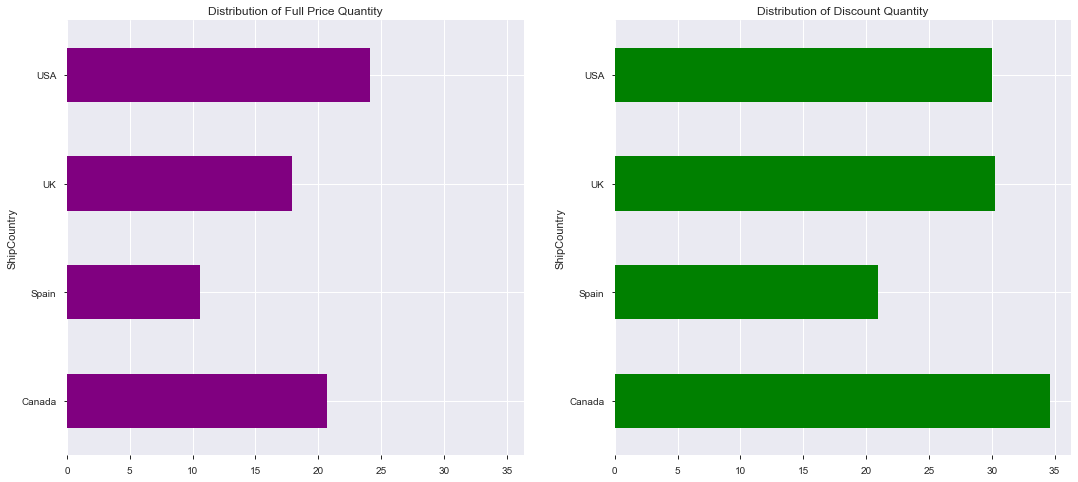

In [332]:
# Plot comparison of discount orders vs fullprice orders for each country where a significant difference exists.
#Spain
q0 = "SELECT ShipCountry, AVG(Quantity) from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, AVG(Quantity) from discountry_df where discounted = 1 group by 1;"

fullprice_df = pysqldf(q0)
discount_df = pysqldf(q1)

# Create histograms for each query group
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8), sharex=True)

ax0 = axes[0]
fullprice_df.set_index('ShipCountry')['AVG(Quantity)'].plot(kind='barh', ax=ax0, color='purple')
ax0.set_title('Distribution of Full Price Quantity')

ax1 = axes[1]
discount_df.set_index('ShipCountry')['AVG(Quantity)'].plot(kind='barh', ax=ax1, color='green')
ax1.set_title('Distribution of Discount Quantity')
plt.show()

The above plots indicate that when a discount is offered, these individual countries do in fact tend to order higher quantities of products. Let's look at the values to determine what percentage more they purchase when an order is discounted.

In [333]:
q0 = "SELECT ShipCountry, AVG(Quantity) as fpmean_qty from discountry_df where discounted = 0 group by 1;"
q1 = "SELECT ShipCountry, AVG(Quantity) as dcmean_qty from discountry_df where discounted = 1 group by 1;"

display(pysqldf(q0), pysqldf(q1))

,ShipCountry,fpmean_qty
0,Canada,20.704545
1,Spain,10.625000
2,UK,17.944954
3,USA,24.123810


,ShipCountry,dcmean_qty
0,Canada,34.612903
1,Spain,20.928571
2,UK,30.230769
3,USA,30.028169


In [337]:
fp = pysqldf(q0)
dc = pysqldf(q1)
country_mean_qty = fp
country_mean_qty['dcmean_qty'] = dc['dcmean_qty']
country_mean_qty                            

,ShipCountry,fpmean_qty,dcmean_qty
0,Canada,20.704545,34.612903
1,Spain,10.625000,20.928571
2,UK,17.944954,30.230769
3,USA,24.123810,30.028169


In [338]:
country_mean_qty['mean_diff'] = country_mean_qty.dcmean_qty - country_mean_qty.fpmean_qty
country_mean_qty

,ShipCountry,fpmean_qty,dcmean_qty,mean_diff
0,Canada,20.704545,34.612903,13.908358
1,Spain,10.625000,20.928571,10.303571
2,UK,17.944954,30.230769,12.285815
3,USA,24.123810,30.028169,5.904359


In [343]:
q3 = "SELECT ShipCountry, AVG(Quantity) as mean_qty from discountry_df group by 1;"
mean_qty = pysqldf(q3)
country_mean_qty['mean_qty'] = mean_qty['mean_qty']
country_mean_qty

,ShipCountry,fpmean_qty,dcmean_qty,mean_diff,mean_qty
0,Canada,20.704545,34.612903,13.908358,26.453333
1,Spain,10.625000,20.928571,10.303571,13.296296
2,UK,17.944954,30.230769,12.285815,20.311111
3,USA,24.123810,30.028169,5.904359,26.505682


## Results

For certain individual countries (Spain, Canada, UK, USA), the null hypothesis is rejected.

# H3: Region--Revenue
**Does average revenue per order vary between different regions of the world?**

**If so, which regions and by how much?**

## Hypotheses

H1: Region has a statistically significant effect on revenue per order.

H0: Region has no relationship with revenue per order.

## EDA

Select the proper dataset for analysis, generate data groups for testing, perform EDA.

### Select

In [375]:
# Extract revenue per product per order
cur.execute("""SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
FROM Customer c
JOIN 'Order' o ON c.Id = o.CustomerId
JOIN OrderDetail od USING(OrderId);""")
df = pd.DataFrame(cur.fetchall())
df. columns = [i[0] for i in cur.description]
print(len(df))
df.head()

2078


,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [376]:
# Get total revenue per order

df['order_revenue'] = df.Quantity * df.UnitPrice * (1-df.Discount)

In [377]:
# Drop unnecessary columns
df.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

### Group

In [378]:
# Group data by order and get sum total revenue for each
df_revenue = df.groupby(['Region', 'OrderId'])['order_revenue'].sum().reset_index()
df_revenue.head()

,Region,OrderId,order_revenue
0,British Isles,10289,479.4
1,British Isles,10298,2645.0
2,British Isles,10309,1762.0
3,British Isles,10315,516.8
4,British Isles,10318,240.4


In [379]:
# drop Order Id (no longer necessary)
df_revenue.drop('OrderId', axis=1, inplace=True)
df_revenue.head()

,Region,order_revenue
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


In [380]:
# Explore sample sizes before testing
df_revenue.groupby('Region').count()

,order_revenue
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


In [381]:
# Group sub-regions together to create sample sizes adequately large for ANOVA testing  (min 30)

# Group Scandinavia, Northern and Eastern Europe
df_revenue.loc[(df_revenue.Region == 'Scandinavia') | (df_revenue.Region == 'Eastern Europe') | (df_revenue.Region == 'Northern Europe'), 'Region'] = 'Northeastern Europe'

# Group South and Central America
df_revenue.loc[(df_revenue.Region == 'South America') | (df_revenue.Region == 'Central America'), 'Region'] = 'South Central America'

# Review sizes of new groups
df_revenue.groupby('Region').count()

,order_revenue
Region,
British Isles,75
North America,152
Northeastern Europe,90
South Central America,148
Southern Europe,64
Western Europe,272


### Explore

Text(0, 0.5, '')

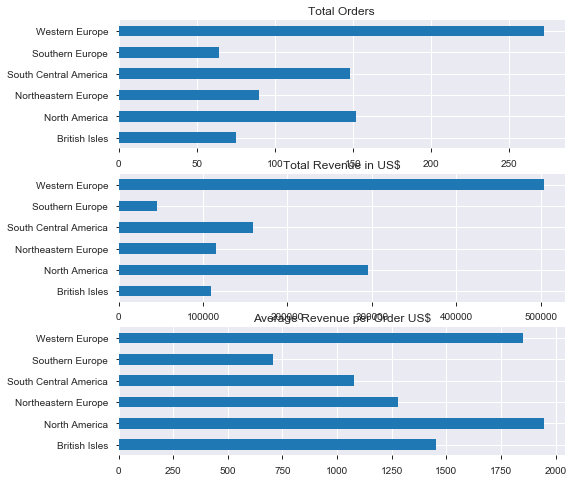

In [383]:
# Plot number of orders, total revenue, and average revenue per order by region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
# Number of orders
df_revenue.groupby(['Region'])['order_revenue'].count().plot(kind='barh', ax=ax1)

# Total Revenue
df_revenue.groupby(['Region'])['order_revenue'].sum().plot(kind='barh', ax=ax2)

# Average Revenue
df_revenue.groupby(['Region'])['order_revenue'].mean().plot(kind='barh', ax=ax3)

# Label plots and axes
ax1.set_title('Total Orders')
ax1.set_ylabel('')
ax2.set_title('Total Revenue in US$')
ax2.set_ylabel('')
ax3.set_title('Average Revenue per Order US$')
ax3.set_ylabel('')

## Test

### Sample Size

### Normality

NormaltestResult(statistic=199.86469478355303, pvalue=3.9804572513114644e-44)
NormaltestResult(statistic=21.777462638840838, pvalue=1.866741029571226e-05)
NormaltestResult(statistic=108.4403079308811, pvalue=2.8345643768585422e-24)
NormaltestResult(statistic=246.73716841152861, pvalue=2.640612283706833e-54)
NormaltestResult(statistic=94.66869009197052, pvalue=2.773033665134401e-21)
NormaltestResult(statistic=79.401544965135, pvalue=5.7302501806918806e-18)


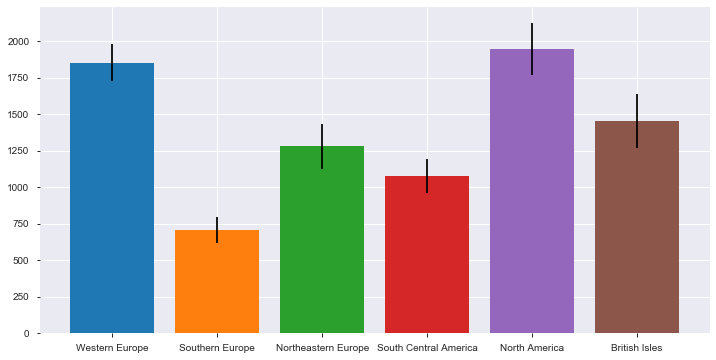

In [484]:
# group by regions
# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons for two groups (normality check)

regions = ['Western Europe', 'Southern Europe', 'Northeastern Europe', 'South Central America', 'North America', 'British Isles']
fig = plt.figure(figsize=(12,6))
for region in regions:
    grp = df_revenue.groupby('Region').get_group(region)['order_revenue']
    plt.bar(x=region, height=grp.mean(), yerr=stat.sem(grp))
    print(stat.normaltest(grp))
plt.show()

### Statistical

In [486]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_revenue['order_revenue'].values
labels = df_revenue['Region'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,British Isles,North America,493.2441,0.3857,-236.7077,1223.1959,False
1,British Isles,Northeastern Europe,-172.3127,0.9,-981.0803,636.4549,False
2,British Isles,South Central America,-376.7646,0.6613,-1109.9682,356.4391,False
3,British Isles,Southern Europe,-746.031,0.1501,-1626.3103,134.2482,False
4,British Isles,Western Europe,398.598,0.5345,-276.0594,1073.2555,False
5,North America,Northeastern Europe,-665.5568,0.0647,-1353.5725,22.4588,False
6,North America,South Central America,-870.0087,0.001,-1467.3763,-272.6411,True
7,North America,Southern Europe,-1239.2751,0.001,-2010.0877,-468.4626,True
8,North America,Western Europe,-94.6461,0.9,-618.5002,429.2081,False
9,Northeastern Europe,South Central America,-204.4519,0.9,-895.9166,487.0129,False


## Results

At an alpha level of 0.05 significance, revenue does vary between regions and therefore the null hypothesis is rejected.

# H4: Season--Revenue
**Does time of year have a statistically significant effect on sales?**

**If so, which months?**

## Hypotheses
    
* $𝐻_1$  : Time of year has a statistically significant effect on the sales revenue or volume of units sold.

* $𝐻_0$ : Time of year has no relationship with sales revenue or volume of units sold.

## EDA
Select the proper dataset for analysis, perform EDA, and generate data groups for testing.

       * group by month: determine mean number of orders, mean order quantity 

### Select

In [354]:
df_month = df_orderDetail.merge(df_order, on='OrderId', copy=True)
df_month.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD,CustomerId,EmployeeId,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear
0,10248/11,10248,11,14.0,12,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
1,10248/42,10248,42,9.8,10,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
2,10248/72,10248,72,34.8,5,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
3,10249/14,10249,14,18.6,9,0.0,0,0.0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
4,10249/51,10249,51,42.4,40,0.0,0,0.0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012


In [355]:
pd.to_datetime(df_month['OrderDate']).head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

In [356]:
pd.to_datetime(df_month['OrderDate'], format='%Y/%m/%d').head()

0   2012-07-04
1   2012-07-04
2   2012-07-04
3   2012-07-05
4   2012-07-05
Name: OrderDate, dtype: datetime64[ns]

In [357]:
df_month['OrderMonth'] = pd.DatetimeIndex(df_month['OrderDate']).month
df_month['OrderYear'] = pd.DatetimeIndex(df_month['OrderDate']).year
df_month.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD,CustomerId,EmployeeId,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear
0,10248/11,10248,11,14.0,12,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
1,10248/42,10248,42,9.8,10,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
2,10248/72,10248,72,34.8,5,0.0,0,0.0,VINET,5,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012
3,10249/14,10249,14,18.6,9,0.0,0,0.0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012
4,10249/51,10249,51,42.4,40,0.0,0,0.0,TOMSP,6,...,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012


### Explore

In [358]:
df_month.OrderMonth.value_counts()

4     261
3     255
1     237
2     201
12    195
10    179
11    155
5     155
8     153
9     152
7     136
6      76
Name: OrderMonth, dtype: int64

In [359]:
#create dict of months and order quantity totals
qty_per_month = {}

for i in list(range(1,13)):
    qty = sum(df_month[df_month.OrderMonth == i].Quantity)
    qty_per_month[i] = qty

qty_per_month

{1: 5867,
 2: 5247,
 3: 5835,
 4: 6592,
 5: 3085,
 6: 1635,
 7: 3516,
 8: 3183,
 9: 3467,
 10: 4417,
 11: 3591,
 12: 4882}

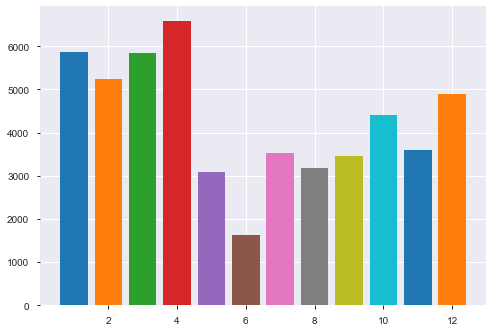

In [360]:
# plot order quantity totals by month
for k,v in qty_per_month.items():
    plt.bar(x=k, height=v)

### Group

In [385]:
months = df_month.groupby('OrderMonth').groups
months.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [399]:
# Group months into seasons
df_month.loc[(df_month.OrderMonth == 12) | (df_month.OrderMonth == 1) | (df_month.OrderMonth == 2), 'Season'] = 'Winter'
df_month.loc[(df_month.OrderMonth == 3) | (df_month.OrderMonth == 4) | (df_month.OrderMonth == 5), 'Season'] = 'Spring'
df_month.loc[(df_month.OrderMonth == 6) | (df_month.OrderMonth == 7) | (df_month.OrderMonth == 8), 'Season'] = 'Summer'
df_month.loc[(df_month.OrderMonth == 9) | (df_month.OrderMonth == 10) | (df_month.OrderMonth == 11), 'Season'] = 'Fall'
df_month.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted,OQD,CustomerId,EmployeeId,...,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,OrderMonth,OrderYear,Season
0,10248/11,10248,11,14.0,12,0.0,0,0.0,VINET,5,...,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012,Summer
1,10248/42,10248,42,9.8,10,0.0,0,0.0,VINET,5,...,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012,Summer
2,10248/72,10248,72,34.8,5,0.0,0,0.0,VINET,5,...,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,7,2012,Summer
3,10249/14,10249,14,18.6,9,0.0,0,0.0,TOMSP,6,...,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012,Summer
4,10249/51,10249,51,42.4,40,0.0,0,0.0,TOMSP,6,...,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,7,2012,Summer


In [405]:
# create seasonal-based dataframe with only columns we need
#keep_cols = ['OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'ShipCountry', 'OrderMonth', 'OrderYear', 'Season']
drop_cols = ['Id', 'Discount', 'discounted', 'OQD', 'CustomerId', 'EmployeeId', 'Freight', 'OrderDate', 'RequiredDate', 'ShippedDate', 'ShipVia', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode']
df_season = df_month.copy()
df_season.drop(drop_cols, axis=1, inplace=True)
df_season.head()

,OrderId,ProductId,UnitPrice,Quantity,ShipCountry,OrderMonth,OrderYear,Season
0,10248,11,14.0,12,France,7,2012,Summer
1,10248,42,9.8,10,France,7,2012,Summer
2,10248,72,34.8,5,France,7,2012,Summer
3,10249,14,18.6,9,Germany,7,2012,Summer
4,10249,51,42.4,40,Germany,7,2012,Summer


In [436]:
# Add another feature to examine: revenue
df_season['Revenue'] = df_season.UnitPrice * df_season.Quantity
df_season.Revenue.mean()

628.5190672853829

In [435]:
# calculate mean order quantities by season
for season in seasons:
    grp_Q = df_season.groupby('Season').get_group(season)['Quantity']
    grp_R = df_season.groupby('Season').get_group(season)['Revenue']
    print(f"{season} ", round(grp_Q.mean(),3), " $", round(grp_R.mean(), 2))

Summer  22.833  $ 551.61
Fall  23.611  $ 606.01
Winter  25.27  $ 697.86
Spring  23.118  $ 621.25


## Test

### Sample Size

NormaltestResult(statistic=151.0560452080266, pvalue=1.5797797913940412e-33)
NormaltestResult(statistic=178.25761189874967, pvalue=1.958174530749427e-39)
NormaltestResult(statistic=251.72311463126775, pvalue=2.1828313074890604e-55)
NormaltestResult(statistic=240.63961435403075, pvalue=5.568928979338427e-53)


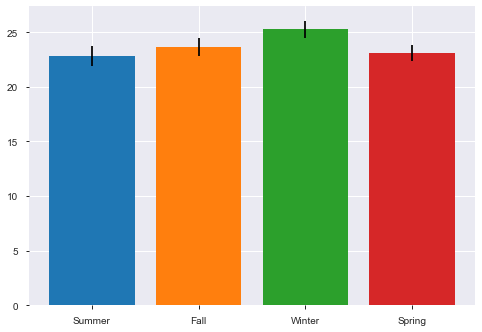

In [426]:
# group by seasons
# Check if sample sizes allow us to ignore assumptions;
# visualize sample size comparisons for two groups (normality check)

seasons = ['Summer', 'Fall', 'Winter', 'Spring']

for season in seasons:
    grp = df_season.groupby('Season').get_group(season)['Quantity']
    plt.bar(x=season, height=grp.mean(), yerr=stat.sem(grp))
    print(stat.normaltest(grp))
plt.show()

### Normality

In [427]:
#stat.normaltest(), stat.normaltest(discount)for season in seasons:
summer = df_season.groupby('Season').get_group('Summer')['Quantity']
fall = df_season.groupby('Season').get_group('Fall')['Quantity']
winter = df_season.groupby('Season').get_group('Winter')['Quantity']
spring = df_season.groupby('Season').get_group('Spring')['Quantity']

In [428]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(summer, winter)

MannwhitneyuResult(statistic=107635.5, pvalue=0.03572648549789337)

In [437]:
# Run non-parametric test (since normality test failed)
stat.mannwhitneyu(spring, winter)

MannwhitneyuResult(statistic=195813.0, pvalue=0.007319161595850691)

### Statistical

In [438]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_season['Quantity'].values
labels = df_season['Season'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Fall,Spring,-0.4934,0.9,-3.4047,2.4179,False
1,Fall,Summer,-0.7782,0.9,-4.1636,2.6071,False
2,Fall,Winter,1.659,0.4711,-1.2888,4.6068,False
3,Spring,Summer,-0.2849,0.9,-3.4637,2.894,False
4,Spring,Winter,2.1524,0.1727,-0.5558,4.8606,False
5,Summer,Winter,2.4373,0.2074,-0.775,5.6496,False


In [439]:
# run tukey test for OQD (Order Quantity Discount) 
data = df_season['Revenue'].values
labels = df_season['Season'].values

import statsmodels.api as sms
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)

# save OQD tukey test model results into dataframe (OQD: order quantity discount)
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Fall,Spring,15.2433,0.9,-143.4065,173.8931,False
1,Fall,Summer,-54.3993,0.8596,-238.8806,130.082,False
2,Fall,Winter,91.8564,0.4571,-68.7812,252.494,False
3,Spring,Summer,-69.6426,0.705,-242.8731,103.588,False
4,Spring,Winter,76.6131,0.5361,-70.967,224.1933,False
5,Summer,Winter,146.2557,0.1383,-28.7972,321.3086,False


## Results

At a significance level of alpha = 0.05, we fail to reject the null hypothesis which states there is no relationship between time of year (season) and sales revenue or volume of units sold. 

# Conclusion

# Future Work

Questions to explore in future analyses might include:

1. Build a product recommendation tool

2. Create discounts or free shipping offers to increase sales volumes past a certain threshold.
- Shipping Costs and Order Quantities/Sales Revenue
*Does shipping cost (freight) have a statistically significant effect on quantity? If so, at what level(s) of shipping cost?*

3. Customer Type and Product Category

*Is there a relationship between type of customer and certain product categories? If so, we can run more highly targeted sales and marketing programs for increasing sales of certain products to certain market segments.* 



# metricks

1. What were the top 3 selling products overall?
2. Top 3 selling products by country?
3. Top 3 selling products by region?
4. How did we do in sales for each product category?
5. Can we group customers into customer types (fill the empty database) and build a product recommendation tool?

In [455]:
# Extract revenue per product category
cur.execute("""SELECT o.OrderId, o.CustomerId, od.ProductId, od.Quantity, od.UnitPrice, 
                od.Quantity*od.UnitPrice*(1-Discount) as Revenue, p.CategoryId, c.CategoryName
                FROM 'Order' o
                JOIN OrderDetail od 
                ON o.OrderId = od.OrderId
                JOIN Product p 
                ON od.ProductId = p.Id
                JOIN Category c
                ON p.CategoryId = c.Id
                ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
print(len(df))
df.head(8)

2155


,OrderId,CustomerId,ProductId,Quantity,UnitPrice,Revenue,CategoryId,CategoryName
0,10248,VINET,11,12,14.0,168.0,4,Dairy Products
1,10248,VINET,42,10,9.8,98.0,5,Grains/Cereals
2,10248,VINET,72,5,34.8,174.0,4,Dairy Products
3,10249,TOMSP,14,9,18.6,167.4,7,Produce
4,10249,TOMSP,51,40,42.4,1696.0,7,Produce
5,10250,HANAR,41,10,7.7,77.0,8,Seafood
6,10250,HANAR,51,35,42.4,1261.4,7,Produce
7,10250,HANAR,65,15,16.8,214.2,2,Condiments


In [465]:
# Group data by Category and get sum total revenue for each
df_category = df.groupby(['CategoryName'])['Revenue'].sum().reset_index()
df_category

,CategoryName,Revenue
0,Beverages,267868.1800
1,Condiments,106047.0850
2,Confections,167357.2250
3,Dairy Products,234507.2850
4,Grains/Cereals,95744.5875
5,Meat/Poultry,163022.3595
6,Produce,99984.5800
7,Seafood,131261.7375


In [473]:
df.CategoryId.value_counts()

1    404
4    366
3    334
8    330
2    216
5    196
6    173
7    136
Name: CategoryId, dtype: int64

In [470]:
# Explore sample sizes before testing
categories = df.groupby('CategoryName').groups
categories.keys()

dict_keys(['Beverages', 'Condiments', 'Confections', 'Dairy Products', 'Grains/Cereals', 'Meat/Poultry', 'Produce', 'Seafood'])

In [460]:
df_category.loc[df_category['CategoryName'] == 'Beverages']['Revenue'].sum()

267868.18

In [476]:
#create dict of months and order quantity totals
rev_per_cat = {}

for k,v in categories.items():
    rev = df_category.loc[df_category['CategoryName'] == k]['Revenue'].sum()
    rev_per_cat[k] = rev

rev_per_cat

{'Beverages': 267868.17999999993,
 'Condiments': 106047.08500000002,
 'Confections': 167357.22499999995,
 'Dairy Products': 234507.285,
 'Grains/Cereals': 95744.58750000001,
 'Meat/Poultry': 163022.3595,
 'Produce': 99984.57999999999,
 'Seafood': 131261.73750000002}

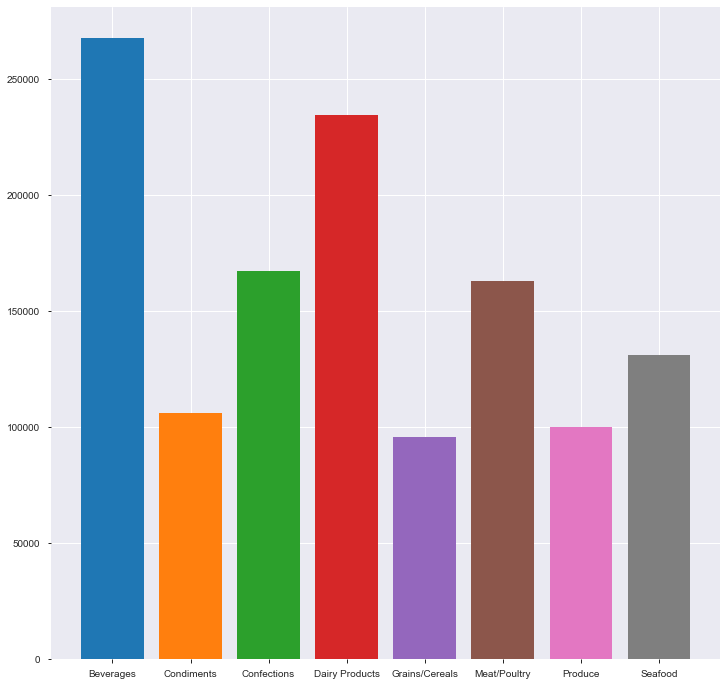

In [479]:
# plot order quantity totals by month
fig = plt.figure(figsize=(12,12))
for k,v in rev_per_cat.items():
    plt.bar(x=k, height=v)

In [ ]:
# What were the top 3 selling product categories in each region or country?
# What were the lowest 3 selling product categories in each region or country?